# TSQR: Communication-Avoiding QR Factorization
**Question 1**

There is a tall-skinny matrix W which is distributed across 4 processors,
TSQR avoids global communication by:

1. Each processor does a local QR dependently.
2. Stack and factorize pairs of R factors.
3. Stack and factorize final pair of R factors.

In [2]:
import numpy as np

## First: Construct the input matrix

A random tall-skinny matrix A is built with m divisible by 4,
so it can be split to 4 processors.

In [3]:
np.random.seed(42)

m = 40  # must be divisible by 4
n = 5   # n << m (tall-skinny)

A = np.random.randn(m, n)
bs = m // 4    # each processor handles 10 lines

print(f"Matrix A: {m} x {n}")
print(f"Each processor block: {bs} rows x {n} cols")
print(f"\nA =\n{np.round(A, 4)}")

Matrix A: 40 x 5
Each processor block: 10 rows x 5 cols

A =
[[ 0.4967 -0.1383  0.6477  1.523  -0.2342]
 [-0.2341  1.5792  0.7674 -0.4695  0.5426]
 [-0.4634 -0.4657  0.242  -1.9133 -1.7249]
 [-0.5623 -1.0128  0.3142 -0.908  -1.4123]
 [ 1.4656 -0.2258  0.0675 -1.4247 -0.5444]
 [ 0.1109 -1.151   0.3757 -0.6006 -0.2917]
 [-0.6017  1.8523 -0.0135 -1.0577  0.8225]
 [-1.2208  0.2089 -1.9597 -1.3282  0.1969]
 [ 0.7385  0.1714 -0.1156 -0.3011 -1.4785]
 [-0.7198 -0.4606  1.0571  0.3436 -1.763 ]
 [ 0.3241 -0.3851 -0.6769  0.6117  1.031 ]
 [ 0.9313 -0.8392 -0.3092  0.3313  0.9755]
 [-0.4792 -0.1857 -1.1063 -1.1962  0.8125]
 [ 1.3562 -0.072   1.0035  0.3616 -0.6451]
 [ 0.3614  1.538  -0.0358  1.5646 -2.6197]
 [ 0.8219  0.087  -0.299   0.0918 -1.9876]
 [-0.2197  0.3571  1.4779 -0.5183 -0.8085]
 [-0.5018  0.9154  0.3288 -0.5298  0.5133]
 [ 0.0971  0.9686 -0.7021 -0.3277 -0.3921]
 [-1.4635  0.2961  0.2611  0.0051 -0.2346]
 [-1.4154 -0.4206 -0.3427 -0.8023 -0.1613]
 [ 0.4041  1.8862  0.1746  0.2576 -0

## Second: For each processor's row block, local QR

Processor i has rows [ i*bs : (i+1)*bs, : ] of A.

    W_i = A[i*bs : (i+1)*bs, :]  →  Q_i0 · R_i0

Only R_i0 is passed upward, Q_i0 stays local and does not participate in communication.

In [4]:
# Create an empty list to store local R matrices of each 4 processors.
R_stage1 = []

for i in range(4):
    W_i = A[i * bs : (i + 1) * bs, :]
    Q_i, R_i = np.linalg.qr(W_i)
    R_stage1.append(R_i)

    print(f"Processor {i}：")
    print(f"  Block shape: {W_i.shape}")
    print(f"  R_{i}0 =\n{np.round(R_i, 4)}\n")

Processor 0：
  Block shape: (10, 5)
  R_00 =
[[-2.4308  0.4209 -0.6368 -0.7804  0.0157]
 [ 0.     -2.9446  0.1458  0.0836 -1.9352]
 [ 0.      0.     -2.4199 -0.8521  1.0498]
 [ 0.      0.      0.      3.3415  1.4061]
 [ 0.      0.      0.      0.     -2.2103]]

Processor 1：
  Block shape: (10, 5)
  R_10 =
[[-2.5097  0.4641 -0.0738 -1.0167  0.947 ]
 [ 0.      2.2453  0.3707  0.705  -2.7747]
 [ 0.      0.      2.3635  0.0174 -0.6648]
 [ 0.      0.      0.      1.9047 -0.6972]
 [ 0.      0.      0.      0.      2.3466]]

Processor 2：
  Block shape: (10, 5)
  R_20 =
[[ 4.1028 -0.8485 -0.0714 -0.7449 -0.0086]
 [ 0.     -2.9465  0.1871 -0.086  -0.2503]
 [ 0.      0.     -3.0538  1.532  -0.2848]
 [ 0.      0.      0.     -2.8882  0.4164]
 [ 0.      0.      0.      0.     -1.8522]]

Processor 3：
  Block shape: (10, 5)
  R_30 =
[[-2.1019  0.8843  0.163  -0.6477  0.657 ]
 [ 0.     -2.6932 -1.4809  1.7197 -0.4927]
 [ 0.      0.     -2.5977  0.2349 -1.1953]
 [ 0.      0.      0.     -1.2109 -0.413

## Third: First reduction - pair up R factors

Stack R_00 and R_10  →  QR  →  R_01

Stack R_20 and R_30  →  QR  →  R_11

In [5]:
R_stage2 = []
pairs = [(0, 1), (2, 3)]     # Processor 0 and 1 are paired, processor 2 and 3 are paired.

for idx, (i, j) in enumerate(pairs):
    stacked = np.vstack([R_stage1[i], R_stage1[j]])     # Two R matrix are stacked vertically, resulting in a (2n × n) matrix, i.e., (10 × 5)
    Q_mid, R_mid = np.linalg.qr(stacked)
    R_stage2.append(R_mid)

    print(f"Pair (R_{i}0, R_{j}0)")
    print(f"  Stacked shape: {stacked.shape}")
    print(f"  R_{idx}1 =\n{np.round(R_mid, 4)}\n")

Pair (R_00, R_10)
  Stacked shape: (10, 5)
  R_01 =
[[ 3.4939 -0.6262  0.4961  1.2733 -0.6911]
 [ 0.      3.703   0.1111  0.3602 -0.14  ]
 [ 0.      0.      3.4283  0.6642 -1.5004]
 [ 0.      0.      0.     -3.9337 -0.3301]
 [ 0.      0.      0.      0.      4.887 ]]

Pair (R_20, R_30)
  Stacked shape: (10, 5)
  R_11 =
[[-4.6099  1.1584  0.1379  0.3677  0.3072]
 [ 0.      4.0119  0.8679 -1.1827  0.5725]
 [ 0.      0.      4.1906 -1.6533  1.0085]
 [ 0.      0.      0.      3.4471 -0.1253]
 [ 0.      0.      0.      0.      3.9323]]



## Fourth: Final reduction — global R

Stack R_01 and R_11  →  QR  →  R_02

R_02 is the final global upper-triangular factor.

In [6]:
stacked_final = np.vstack([R_stage2[0], R_stage2[1]])
Q_final, R_final = np.linalg.qr(stacked_final)

print("Final reduction: ")
print(f"  Stacked shape: {stacked_final.shape}")
print(f"\nFinal R (= R_02) =\n{np.round(R_final, 4)}")

Final reduction: 
  Stacked shape: (10, 5)

Final R (= R_02) =
[[-5.7843  1.3014 -0.1898 -0.4761  0.6623]
 [ 0.     -5.4633 -0.7302  0.5789 -0.3122]
 [ 0.      0.     -5.4567  0.8472  0.1538]
 [ 0.      0.      0.      5.7041 -0.513 ]
 [ 0.      0.      0.      0.     -6.5449]]


## Verification

Three checks:

**Check 1:** R_final is upper triangular

**Check 2:** ||A^T A - R^T R||_F ≈ 0

**Check 3:** R_final matches numpy built-in QR (sign-adjusted)

Note (Slide 20): QR is unique up to sign of columns of Q.

In [7]:
# Verify R is an upper triangular matrix
residual = np.linalg.norm(R_final - np.triu(R_final), ord='fro')
print(f"\n[1] ||R - triu(R)||_F       = {residual:.2e}")
print(f"    R is upper triangular   : {residual < 1e-10}")

# Verify numerical equivalence
err_ATA = np.linalg.norm(A.T @ A - R_final.T @ R_final, ord='fro')
print(f"\n[2] ||A^T A - R^T R||_F    = {err_ATA:.2e}  (should be ~0)")

# Compare with inside QR
_, R_ref = np.linalg.qr(A)
# Make all diagonal elements be positive and then compare them
def fix_sign(R):
    signs = np.sign(np.diag(R))
    return np.diag(signs) @ R

err_ref = np.linalg.norm(fix_sign(R_final) - fix_sign(R_ref), ord='fro')
print(f"\n[3] ||R_tsqr - R_numpy||_F = {err_ref:.2e}  (should be ~0)")

# Final: error should less than 1e-10
if err_ATA < 1e-10 and err_ref < 1e-10:
    print("  All checks passed — TSQR is correct")
else:
    print("  Warning: some checks failed.")


[1] ||R - triu(R)||_F       = 0.00e+00
    R is upper triangular   : True

[2] ||A^T A - R^T R||_F    = 2.91e-14  (should be ~0)

[3] ||R_tsqr - R_numpy||_F = 3.51e-15  (should be ~0)
  All checks passed — TSQR is correct


## Question 3: Scaling Analysis

Test how TSQR runtime scales with respect to m and n.
Fix n=5, vary m: 40, 80, 160, 320, 640, 1280, 2560
Fix m=400, vary n: 5, 10, 20, 40, 80, 100

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

      m  n      time
0    40  5  0.000037
1    80  5  0.000026
2   160  5  0.000026
3   320  5  0.000029
4   640  5  0.000037
5  1280  5  0.000101
6  2560  5  0.000087


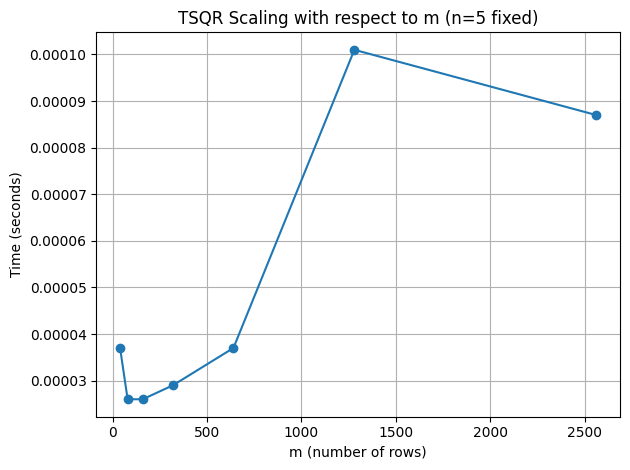

In [2]:
df_m = pd.read_csv('/Users/niuxinyue/Ass1-CAQR/tsqr_c/scale_m.csv')
print(df_m)

plt.figure()
plt.plot(df_m['m'], df_m['time'], marker='o')
plt.xlabel('m (number of rows)')
plt.ylabel('Time (seconds)')
plt.title('TSQR Scaling with respect to m (n=5 fixed)')
plt.grid(True)
plt.tight_layout()
plt.savefig('scaling_m.png', dpi=150)
plt.show()

### Scaling with respect to n (fixed m=400)

     m    n      time
0  400    5  0.000037
1  400   10  0.000048
2  400   20  0.000116
3  400   40  0.000314
4  400   80  0.001063
5  400  100  0.001244


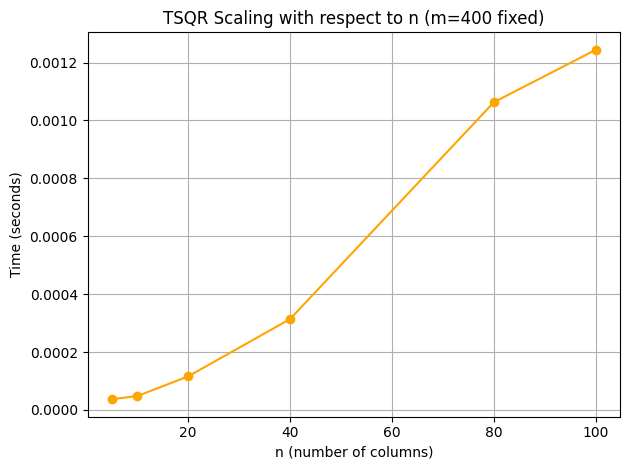

In [3]:
df_n = pd.read_csv('/Users/niuxinyue/Ass1-CAQR/tsqr_c/scale_n.csv')
print(df_n)

plt.figure()
plt.plot(df_n['n'], df_n['time'], marker='o', color='orange')
plt.xlabel('n (number of columns)')
plt.ylabel('Time (seconds)')
plt.title('TSQR Scaling with respect to n (m=400 fixed)')
plt.grid(True)
plt.tight_layout()
plt.savefig('scaling_n.png', dpi=150)
plt.show()